In [1]:
#Import libraries
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
data = pd.read_csv('FinancialData.csv', names=['Label', 'Text'], encoding='latin-1')

In [3]:
data

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4846 non-null   object
 1   Text    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [5]:
#Preprocessing
def get_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)
    
    max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    print("Maximum sequence length:", max_seq_length)
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [6]:
def preprocess_inputs(df):
    df = df.copy()
    
    sequences = get_sequences(df['Text'])
    
    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    
    y = df['Label'].replace(label_mapping)
    
    train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, y, train_size=0.7, shuffle=True, random_state=1)
    
    return train_sequences, test_sequences, y_train, y_test

In [7]:
train_sequences, test_sequences, y_train, y_test = preprocess_inputs(data)

Vocab length: 10123
Maximum sequence length: 71


In [8]:
train_sequences

array([[5442,  510,   16, ...,    0,    0,    0],
       [  22, 1628,    4, ...,    0,    0,    0],
       [1141,  936,  136, ...,    0,    0,    0],
       ...,
       [   1,  419,   16, ...,    0,    0,    0],
       [2586,  123, 3247, ...,    0,    0,    0],
       [  30,  615,  555, ...,    0,    0,    0]])

In [9]:
y_train

545     2
2374    0
4217    1
1071    1
716     2
       ..
2895    1
2763    1
905     2
3980    1
235     2
Name: Label, Length: 3392, dtype: int64

In [10]:
#Training
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(
    input_dim=10123,
    output_dim=128,
    input_length=train_sequences.shape[1]
)(inputs)
x = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_sequences,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
85/85 [==============================] - 19s 134ms/step - loss: 0.8356 - accuracy: 0.6403 - val_loss: 0.7884 - val_accuracy: 0.6495
Epoch 2/100
85/85 [==============================] - 11s 126ms/step - loss: 0.4797 - accuracy: 0.8039 - val_loss: 0.7658 - val_accuracy: 0.6716
Epoch 3/100
85/85 [==============================] - 11s 130ms/step - loss: 0.1669 - accuracy: 0.9510 - val_loss: 0.9285 - val_accuracy: 0.7143
Epoch 4/100
85/85 [==============================] - 11s 133ms/step - loss: 0.0496 - accuracy: 0.9860 - val_loss: 1.0044 - val_accuracy: 0.6937
Epoch 5/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 1.3899 - val_accuracy: 0.6745


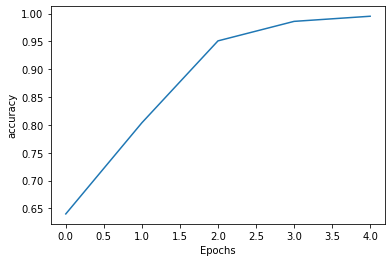

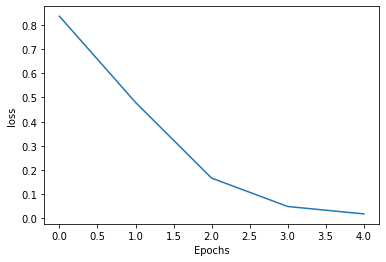

In [12]:
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
# Getting the model summary 
model.summary()

# Saving the model 
model.save("financial_sentiment_analysis-model-v1.0")

print("MODEL SAVED SUCCESSFULLY")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 embedding (Embedding)       (None, 71, 128)           1295744   
                                                                 
 gru (GRU)                   (None, 71, 256)           296448    
                                                                 
 flatten (Flatten)           (None, 18176)             0         
                                                                 
 dense (Dense)               (None, 3)                 54531     
                                                                 
Total params: 1,646,723
Trainable params: 1,646,723
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: financial_sentiment_analysis-model-v1.0\assets


INFO:tensorflow:Assets written to: financial_sentiment_analysis-model-v1.0\assets


MODEL SAVED SUCCESSFULLY
